In [2]:
from matplotlib import image
from matplotlib import pyplot as plt

In [3]:
import os

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np
import xarray as xr
import rioxarray as rxr
import earthpy as et
import earthpy.plot as ep

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [5]:
from sklearn.neighbors import KNeighborsClassifier


In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
from osgeo import gdal
from osgeo import ogr
from osgeo import osr

In [8]:
import random

In [9]:
from tqdm import tqdm

In [10]:
import pandas as pd

In [11]:
from sklearn import model_selection, metrics

In [12]:
%run technical_functions/cv_and_reclassification_methods.ipynb

In [13]:
%run technical_functions/functions_geotransforms.ipynb

Работаем с тензором признаков GLRLM-матрицы.

In [14]:
T = np.load('properties_55/GLRLM_properties_55_64.npy')

In [15]:
T.shape

(424, 448, 11)

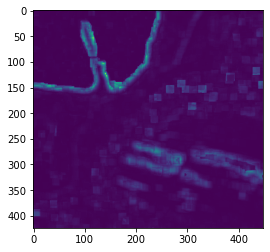

In [16]:
plt.imshow(T[:, :, 2])

Сейчас будем загружать карту. Нужно заметить, что карта у нас с геопривязкой к одноканальному изображению. Надо ее сделать такого же разрешения, как и многоканальное изображение, и привязать к нему.

In [17]:
map_konst = gdal.Open('Konstantinovsky_map.tif')

In [18]:
konstantinovsky_mult = rxr.open_rasterio("geotiff/Konstantinovky_TestReg_mult.tif") #мы хотим шагать по карте по пикселям многоканального изображения

In [19]:
konstantinovsky_mult_gdal = gdal.Open("geotiff/Konstantinovky_TestReg_mult.tif")

In [20]:
map_konst_rasterio = rxr.open_rasterio("Konstantinovsky_map.tif").squeeze()

In [21]:
map_konst_rasterio.values.shape

(1694, 1793)

In [22]:
m_m, m_n = konstantinovsky_mult.shape[1], konstantinovsky_mult.shape[2]
geo_trans_mult = konstantinovsky_mult_gdal.GetGeoTransform()
proj_mult = konstantinovsky_mult_gdal.GetProjection()
geo_trans_pan = map_konst.GetGeoTransform()
proj_pan = map_konst.GetProjection()
pixels_pan_list = []
for i in range(1, m_m + 1):
    a = []
    for j in range(1, m_n + 1):
        a.append((i, j))
    a_coords = pix2coord(a, geo_trans_mult, proj_mult) #были пиксели в мультиканальном, стали координаты
    a_pixels_in_pan = coord2pix(a_coords, geo_trans_pan, proj_pan)
    pixels_pan_list.append(a_pixels_in_pan)

In [23]:
map_konst_ = np.zeros((T.shape[0], T.shape[1]))
cnt_i = 0
cnt_j = 0
for line in tqdm(pixels_pan_list):
    cnt_j = 0
    for elem in line:
        i, j = elem
        i = int(i - 1)
        j = int(j - 1)
        map_konst_[cnt_i][cnt_j] = map_konst_rasterio.values[i][j]
        cnt_j += 1
    cnt_i += 1

100%|███████████████████████████████████████████████████████████████████████████████| 424/424 [00:03<00:00, 129.98it/s]


In [24]:
map_konst_.shape

(424, 448)

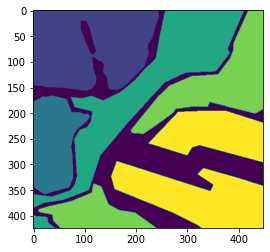

In [25]:
plt.imshow(map_konst_)

In [29]:
#rows, cols = map_konst_.shape[0], map_konst_.shape[1]
#ds = gdal.Open("geotiff/Konstantinovky_TestReg_mult.tif")
#outFileName = "Konstantinovsky_map_mult_geotrans.tif"
#driver = gdal.GetDriverByName("GTiff")
#outdata = driver.Create(outFileName, cols, rows, 1, gdal.GDT_UInt16)
#outdata.SetGeoTransform(ds.GetGeoTransform())##sets same geotransform as input
#outdata.SetProjection(ds.GetProjection())##sets same projection as input
#outdata.GetRasterBand(1).WriteArray(map_konst_)
#outdata.FlushCache()

In [26]:
import skimage.io
import skimage.filters

sigma = 7.0
for i in range(11):
    T[:, :, i] = skimage.filters.gaussian(
        T[:, :, i], sigma=(sigma, sigma), truncate=3.5, multichannel=False)

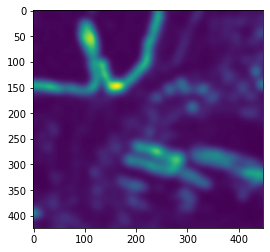

In [27]:
plt.imshow(T[:, :, 2])

In [29]:
from sklearn.preprocessing import StandardScaler
T = T.reshape((T.shape[0] * T.shape[1], 11))
scaler = StandardScaler()
T = scaler.fit_transform(T)

In [30]:
map_konst_ = map_konst_.reshape((map_konst_.shape[0] * map_konst_.shape[1], 1))

In [31]:
data = np.concatenate((T, map_konst_), axis = 1)

In [32]:
import random
ones = data[np.argwhere(map_konst_.squeeze() == 1), :].squeeze()
data_ = np.array(random.sample(list(ones), 10000))
for i in range(2, 6):
    tmp = data[np.argwhere(map_konst_.squeeze() == i), :].squeeze()
    data_ = np.concatenate((data_, np.array(random.sample(list(tmp), 10000))), axis = 0)

In [33]:
data_.shape

(50000, 12)

In [34]:
X = data_[:, :11]
y = data_[:, 11]

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify = y)

In [36]:
qda = QuadraticDiscriminantAnalysis()

In [37]:
qda.fit(X_train, y_train)

QuadraticDiscriminantAnalysis()

In [40]:
pred_qda = qda.predict(T)

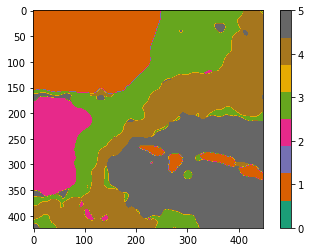

In [41]:
plt.imshow(pred_qda.reshape(424, 448), cmap=plt.get_cmap('Dark2'), vmin=0, vmax=5)
plt.colorbar()

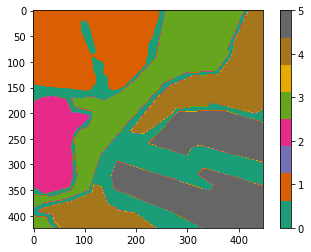

In [39]:
plt.imshow(map_konst_, cmap=plt.get_cmap('Dark2'))
plt.colorbar()

In [40]:
q = QuadraticDiscriminantAnalysis()
mt = model_test(q, X_train, y_train, ['1', '2', '3', '4', '5'])
mt[3]

[                  10-fold cross-validation
                                      Value
 Accuracy                          0.984922
 Kappa Coefficient                 0.981153,
                   Reclassification
                              Value
 Accuracy                  0.984812
 Kappa Coefficient         0.981015]

Попробуем выбирать признаки поочередно.

In [41]:
accuracy_arr_1_layer = []
for t in tqdm(range(11)):
    T_layer0 = T[:, :, t]
    X = []
    y = []
    cnt = np.zeros(5)
    for i in range(T_layer0.shape[0]):
        for j in range(T_layer0.shape[1]):
            if map_konst_[i][j] != 0 and cnt[int(map_konst_[i][j])- 1] < 9500:
                X.append(T_layer0[i, j])
                y.append(map_konst_[i, j])
                cnt[int(map_konst_[i][j])- 1] += 1
    X = np.array(X)
    y = np.array(y)
    X = X.reshape((-1, 1))
    arr = [1] * 9500 + [2] * 9500 + [3] * 9500 + [4] * 9500 + [5] * 9500
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify = arr)
    q = QuadraticDiscriminantAnalysis()
    mt = model_test(q, X_train, y_train, ['1', '2', '3', '4', '5'])
    accuracy_arr_1_layer.append((t, mt[3][0].values[0]))

  0%|          | 0/11 [00:00<?, ?it/s]

In [42]:
accuracy_arr_1_layer

[(0, array([0.68087886])),
 (1, array([0.47902757])),
 (2, array([0.37329323])),
 (3, array([0.61715957])),
 (4, array([0.67368421])),
 (5, array([0.51557561])),
 (6, array([0.66942356])),
 (7, array([0.41963241])),
 (8, array([0.65075021])),
 (9, array([0.62019048])),
 (10, array([0.35301587]))]

In [43]:
T_layer0 = T[:, :, 0]
X = []
y = []
cnt = np.zeros(5)
for i in range(T_layer0.shape[0]):
    for j in range(T_layer0.shape[1]):
        if map_konst_[i][j] != 0 and cnt[int(map_konst_[i][j])- 1] < 9500:
            X.append(T_layer0[i, j])
            y.append(map_konst_[i, j])
            cnt[int(map_konst_[i][j])- 1] += 1
X = np.array(X)
y = np.array(y)
X = X.reshape((-1, 1))
arr = [1] * 9500 + [2] * 9500 + [3] * 9500 + [4] * 9500 + [5] * 9500
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify = arr)
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
pred_qda = qda.predict(T_layer0.reshape(424 * 448, 1))

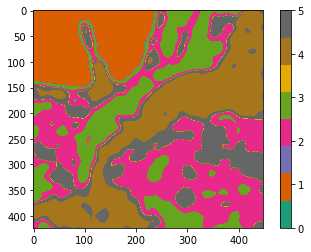

In [44]:
plt.imshow(pred_qda.reshape(T.shape[0], T.shape[1]), cmap=plt.get_cmap('Dark2'), vmin=0, vmax=5)
plt.colorbar()

Наибольшую accuracy дает 0 слой. Будем поочередно пробовать добавлять к нему другие слои.

In [45]:
accuracy_arr_2_layers = []
for t in tqdm(range(11)):
    if t != 0:
        T_layer1 = np.stack((T_layer0, T[:, :, t]), axis = 2)
        X = []
        y = []
        cnt = np.zeros(5)
        for i in range(T_layer1.shape[0]):
            for j in range(T_layer1.shape[1]):
                if map_konst_[i][j] != 0 and cnt[int(map_konst_[i][j])- 1] < 9500:
                    X.append(T_layer1[i, j])
                    y.append(map_konst_[i, j])
                    cnt[int(map_konst_[i][j])- 1] += 1
        X = np.array(X)
        y = np.array(y)
        arr = [1] * 9500 + [2] * 9500 + [3] * 9500 + [4] * 9500 + [5] * 9500
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify = arr)
        q = QuadraticDiscriminantAnalysis()
        mt = model_test(q, X_train, y_train, ['1', '2', '3', '4', '5'])
        accuracy_arr_2_layers.append((t, mt[3][0].values[0]))

  0%|          | 0/11 [00:00<?, ?it/s]

In [46]:
accuracy_arr_2_layers

[(1, array([0.80118296])),
 (2, array([0.76597828])),
 (3, array([0.7686249])),
 (4, array([0.78131997])),
 (5, array([0.82686717])),
 (6, array([0.83343024])),
 (7, array([0.78488555])),
 (8, array([0.77281203])),
 (9, array([0.84470175])),
 (10, array([0.72045113]))]

Лучший результат со слоями (0, 9). Построим их:

In [47]:
T_layer1 = np.stack((T_layer0, T[:, :, 9]), axis = 2)
X = []
y = []
cnt = np.zeros(5)
for i in range(T_layer1.shape[0]):
    for j in range(T_layer1.shape[1]):
        if map_konst_[i][j] != 0 and cnt[int(map_konst_[i][j])- 1] < 9500:
            X.append(T_layer1[i, j])
            y.append(map_konst_[i, j])
            cnt[int(map_konst_[i][j])- 1] += 1
X = np.array(X)
y = np.array(y)
arr = [1] * 9500 + [2] * 9500 + [3] * 9500 + [4] * 9500 + [5] * 9500
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify = arr)

In [48]:
qda = QuadraticDiscriminantAnalysis()

In [49]:
qda.fit(X_train, y_train)

QuadraticDiscriminantAnalysis()

In [50]:
pred_qda = qda.predict(T_layer1.reshape(424 * 448, 2))

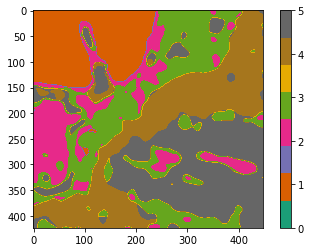

In [51]:
plt.imshow(pred_qda.reshape(T.shape[0], T.shape[1]), cmap=plt.get_cmap('Dark2'), vmin=0, vmax=5)
plt.colorbar()

Добавим еще слой.

In [52]:
accuracy_arr_3_layers = []
for t in tqdm(range(11)):
    if t != 0 and t != 9:
        T_layer2 = np.stack((T[:, :, 0], T[:, :, 9], T[:, :, t]), axis = 2)
        X = []
        y = []
        cnt = np.zeros(5)
        for i in range(T_layer2.shape[0]):
            for j in range(T_layer2.shape[1]):
                if map_konst_[i][j] != 0 and cnt[int(map_konst_[i][j])- 1] < 9500:
                    X.append(T_layer2[i, j])
                    y.append(map_konst_[i, j])
                    cnt[int(map_konst_[i][j])- 1] += 1
        X = np.array(X)
        y = np.array(y)
        arr = [1] * 9500 + [2] * 9500 + [3] * 9500 + [4] * 9500 + [5] * 9500
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify = arr)
        q = QuadraticDiscriminantAnalysis()
        mt = model_test(q, X_train, y_train, ['1', '2', '3', '4', '5'])
        accuracy_arr_3_layers.append((t, mt[3][0].values[0]))

  0%|          | 0/11 [00:00<?, ?it/s]

In [53]:
accuracy_arr_3_layers

[(1, array([0.90264327])),
 (2, array([0.89826566])),
 (3, array([0.92120635])),
 (4, array([0.89745698])),
 (5, array([0.89137845])),
 (6, array([0.93179616])),
 (7, array([0.87672849])),
 (8, array([0.92290058])),
 (10, array([0.86258312]))]

Точность максимальная при (0, 9, 6).

In [54]:
accuracy_arr_4_layers = []
for t in tqdm(range(11)):
    if t != 0 and t != 6 and t != 9:
        T_layer3 = np.stack((T[:, :, 0], T[:, :, 9], T[:, :, 6], T[:, :, t]), axis = 2)
        X = []
        y = []
        cnt = np.zeros(5)
        for i in range(T_layer3.shape[0]):
            for j in range(T_layer3.shape[1]):
                if map_konst_[i][j] != 0 and cnt[int(map_konst_[i][j])- 1] < 9500:
                    X.append(T_layer3[i, j])
                    y.append(map_konst_[i, j])
                    cnt[int(map_konst_[i][j])- 1] += 1
        X = np.array(X)
        y = np.array(y)
        arr = [1] * 9500 + [2] * 9500 + [3] * 9500 + [4] * 9500 + [5] * 9500
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify = arr)
        q = QuadraticDiscriminantAnalysis()
        mt = model_test(q, X_train, y_train, ['1', '2', '3', '4', '5'])
        accuracy_arr_4_layers.append((t, mt[3][0].values[0]))

  0%|          | 0/11 [00:00<?, ?it/s]

In [55]:
accuracy_arr_4_layers

[(1, array([0.93876023])),
 (2, array([0.95223058])),
 (3, array([0.94511947])),
 (4, array([0.94411362])),
 (5, array([0.94803676])),
 (7, array([0.94294737])),
 (8, array([0.94678363])),
 (10, array([0.93687552]))]

In [56]:
T_layer3 = np.stack((T[:, :, 0], T[:, :, 9], T[:, :, 6], T[:, :, 2]), axis = 2)
X = []
y = []
cnt = np.zeros(5)
for i in range(T_layer3.shape[0]):
    for j in range(T_layer3.shape[1]):
        if map_konst_[i][j] != 0 and cnt[int(map_konst_[i][j])- 1] < 9500:
            X.append(T_layer3[i, j])
            y.append(map_konst_[i, j])
            cnt[int(map_konst_[i][j])- 1] += 1
X = np.array(X)
y = np.array(y)
arr = [1] * 9500 + [2] * 9500 + [3] * 9500 + [4] * 9500 + [5] * 9500
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify = arr)
q = QuadraticDiscriminantAnalysis()
q.fit(X_train, y_train)

QuadraticDiscriminantAnalysis()

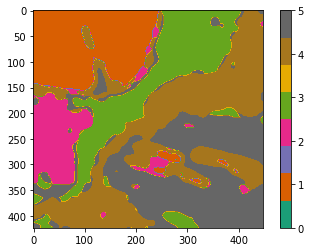

In [57]:
pred_qda = q.predict(T_layer3.reshape(424 * 448, 4))
plt.imshow(pred_qda.reshape(T.shape[0], T.shape[1]), cmap=plt.get_cmap('Dark2'), vmin=0, vmax=5)
plt.colorbar()

In [58]:
import copy

In [59]:
accuracy_arr_5_layers = []
for t in tqdm(range(11)):
    if t != 0 and t != 9 and t != 6 and t != 2:
        T_layer4 = copy.deepcopy(np.stack((T[:, :, 0], T[:, :, 9], T[:, :, 6], T[:, :, 2], T[:, :, t]), axis = 2))
        X = []
        y = []
        cnt = np.zeros(5)
        for i in range(T_layer4.shape[0]):
            for j in range(T_layer4.shape[1]):
                if map_konst_[i][j] != 0 and cnt[int(map_konst_[i][j])- 1] < 9500:
                    X.append(T_layer4[i, j])
                    y.append(map_konst_[i, j])
                    cnt[int(map_konst_[i][j])- 1] += 1
        X = np.array(X)
        y = np.array(y)
        arr = [1] * 9500 + [2] * 9500 + [3] * 9500 + [4] * 9500 + [5] * 9500
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify = arr)
        q = QuadraticDiscriminantAnalysis()
        mt = model_test(q, X_train, y_train, ['1', '2', '3', '4', '5'])
        accuracy_arr_5_layers.append((t, mt[3][0].values[0]))

  0%|          | 0/11 [00:00<?, ?it/s]

In [60]:
accuracy_arr_5_layers

[(1, array([0.96602506])),
 (3, array([0.96240602])),
 (4, array([0.96027402])),
 (5, array([0.96374269])),
 (7, array([0.96055806])),
 (8, array([0.95934503])),
 (10, array([0.95470677]))]

In [61]:
T_layer4 = copy.deepcopy(np.stack((T[:, :, 0], T[:, :, 9], T[:, :, 6], T[:, :, 2], T[:, :, 1]), axis = 2))
X = []
y = []
cnt = np.zeros(5)
for i in range(T_layer4.shape[0]):
    for j in range(T_layer4.shape[1]):
        if map_konst_[i][j] != 0 and cnt[int(map_konst_[i][j])- 1] < 9500:
            X.append(T_layer4[i, j])
            y.append(map_konst_[i, j])
            cnt[int(map_konst_[i][j])- 1] += 1
X = np.array(X)
y = np.array(y)
arr = [1] * 9500 + [2] * 9500 + [3] * 9500 + [4] * 9500 + [5] * 9500
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify = arr)
q = QuadraticDiscriminantAnalysis()
q.fit(X_train, y_train)

QuadraticDiscriminantAnalysis()

In [92]:
mt = model_test(q, X_train, y_train, ['1', '2', '3', '4', '5'])
mt[4]

10-fold cross-validation                                       \
            Omission error Commission error Producer’s accuracy   
1                 0.006253         0.000000            0.993747   
2                 0.019970         0.003421            0.980030   
3                 0.024049         0.043053            0.975951   
4                 0.033482         0.070678            0.966518   
5                 0.086103         0.050931            0.913897   

                   
  User’s accuracy  
1        1.000000  
2        0.996579  
3        0.956947  
4        0.929322  
5        0.949069

In [91]:
mt[5].to_excel("results/GLRLM_rcls_errors.xlsx")

In [93]:
mt[4].to_excel("results/GLRLM_cv_errors.xlsx")

In [98]:
mt[1][0].to_excel("results/GLRLM_cv_conf_matrix.xlsx")

In [99]:
mt[1][1].to_excel("results/GLRLM_rcls_conf_matrix.xlsx")

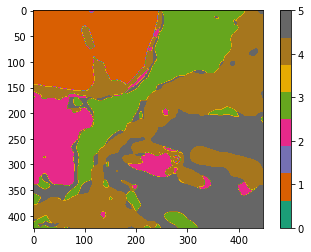

In [63]:
pred_qda = q.predict(T_layer4.reshape(424 * 448, 5))
plt.imshow(pred_qda.reshape(T.shape[0], T.shape[1]), cmap=plt.get_cmap('Dark2'), vmin=0, vmax=5)
plt.colorbar()

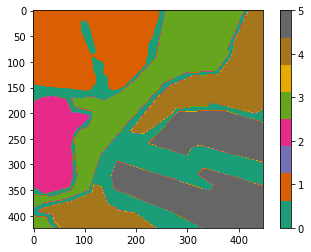

In [64]:
plt.imshow(map_konst_, cmap=plt.get_cmap('Dark2'))
plt.colorbar()

In [66]:
pic = pred_qda.reshape(T.shape[0], T.shape[1])
rows, cols = pic.shape[0], pic.shape[1]
ds = gdal.Open("geotiff/Konstantinovky_TestReg_mult.tif")
outFileName = "results/Konstantinovsky_GLRLM.tif"

In [67]:
driver = gdal.GetDriverByName("GTiff")
outdata = driver.Create(outFileName, cols, rows, 1, gdal.GDT_UInt16)
outdata.SetGeoTransform(ds.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(ds.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(pic)
outdata.FlushCache()